# [PEAK Threat Hunting] M-ATH for Dictionary-based Domain Generation Algorithms

This notebook was created in conjunction with the Splunk SURGe <a href="https://www.splunk.com/en_us/blog/security/threat-hunting-for-dictionary-dga-with-peak.html" target="_blank">"Threat Hunting for Dictionary-DGA"</a> blog post to demonstrate development of Model-Assisted Threat Hunting approach for detecting Dictionary-based Domain Generation Algorithms, as part of the PEAK Threat Hunting Framework. The notebook is built from the barebone_template.ipynb example workflow built into the Deep Learning and Data Science Toolkit, including how to work on custom containerized code that seamlessly interfaces with your Splunk platform. Find more examples and information in the app and on the [DSDL Splunkbase page](https://splunkbase.splunk.com/app/4607/#/details).

Note: By default every time you save this notebook the stages main cells are exported into a python module which can then get invoked by Splunk's MLTK SPL commands like <code> | fit .../ | apply ... | summary </code>. Please read the Model Development Guide in the DSDL app for more information about this workflow.

<img src="https://www.splunk.com/content/dam/splunk-blogs/images/en_us/2022/05/fetterman-math-conclusions.png" alt="PEAK Threat Hunting, by SURGe" style="width: 30%;">

## Stage 0 - import libraries
At stage 0 we define all imports necessary to run our subsequent code.

In [ ]:
# this definition exposes all python module imports that should be available in all subsequent commands
import os
import time
import math
import pandas as pd
import json
import tensorflow as tf
import numpy as np
from tqdm import tqdm
import pickle

import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(filters='\t\n', char_level=True)
from tensorflow.keras.callbacks import TensorBoard

import matplotlib.pyplot as plt
# ...
# Model directory will need to be changed if not using DSDL
MODEL_DIRECTORY = "/srv/app/model/data/"
max_domain_length=253

In [2]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print("numpy version: " + np.__version__)
print("pandas version: " + pd.__version__)
print("tensorflow version: " + pd.__version__)
print("keras version: " + keras.__version__)

numpy version: 1.23.5
pandas version: 2.0.2
tensorflow version: 2.0.2
keras version: 2.12.0


### Stage 1 - Push data from Splunk

There are multiple methods to interact with your Splunk data through DSDL. See the barebones_template.ipynb for options to stream or directly query the REST API. For this notebook, we run a search in Splunk to push a batch of data to run through the model. This should ideally be a deduplicated domain list, e.g.:

    | tstats count FROM datamodel="Web" WHERE nodename="Web" BY host
    | stats dc(host) as count by host
    | fields host
    | rename host as domain
    | fit MLTKContainer mode=stage algo=dict_dga domain into app:dict_dga
    
This notebook only depends on the field to analyze being named "domain", and the batch of data being staged as 'dict_dga' -- otherwise, modify the next cell. 

In [3]:
# staging function
def stage(name):
    with open("data/"+name+".csv", 'r') as f:
        df = pd.read_csv(f)
    with open("data/"+name+".json", 'r') as f:
        param = json.load(f)
    return df, param

In [6]:
# replace file name if you used something other than "dict_dga" in your SPL staging search
df, param = stage("dict_dga")

In [ ]:
# Preserve full domain for analysis, domain field goes through pre-processing
df['orig_domain'] = df['domain'].copy()

## Stage 2 - create and initialize a model
Since this is a supervised learning-based hunt, model training and optimization have been conducted separately, and we can just load the pre-trained model.

Before executing this cell, import the `dict_dga.zip` file from the GitHub repo, into the path set for `MODEL_DIRECTORY`, and unzip the file.

In [7]:
model = tf.keras.models.load_model(MODEL_DIRECTORY + 'm-ath_dict_dga_model')

In [8]:
# initialize your model
# available inputs: data and parameters
# returns the model object which will be used as a reference to call fit, apply and summary subsequently
def init(df,param):
    model = tf.keras.models.load_model(MODEL_DIRECTORY + "dict-DGA")
    return model

## Stage 3 - apply the model
We preprocess the domains to remove the TLDs, then use an LSTM-based neural network to predict the categorization of a domain between 0 (legitimate domain), and 1 (dictionary-based DGA). No other feature engineering is needed.

In [9]:
def predict(domain):
    seq = tokenizer.texts_to_sequences([domain])
    X = sequence.pad_sequences(seq, maxlen=max_domain_length)
    prediction = model.predict(X)
    print(prediction)

In [11]:
# Load the tokenizer
tokenizer = pickle.load(open(MODEL_DIRECTORY + "m-ath_pretrain_tokenizer.pkl", 'rb'))

In [10]:
# Load the word list
with open(MODEL_DIRECTORY + 'm-ath_pretrain_word_list.pkl', 'rb') as f:
    word_list = pickle.load(f)

In [11]:
def preprocess(url):
    pos = url.rfind('.') # find rightmost dot
    if pos >= 0:         # found one
        url = url[:pos]
    return url

def predict(row):
    domain = row['domain']
    seq = tokenizer.texts_to_sequences([domain])
    X = sequence.pad_sequences(seq, maxlen=max_domain_length)
    prediction = model.predict(X, verbose=0)
    return prediction

In [15]:
# Pre-process sample
batch_size = 10000
num_batches = math.ceil(len(df) / batch_size)

for batch_index in range(num_batches):
    start_index = batch_index * batch_size
    end_index = min((batch_index + 1) * batch_size, len(df))

    batch_df = df.iloc[start_index:end_index]
    for index, row in tqdm(batch_df.iterrows(), total=len(batch_df), desc=f"Processing Batch {batch_index+1}/{num_batches}"):
        df.at[index, 'domain'] = preprocess(row['domain'])

Processing Batch 10/10: 100%|██████████| 9995/9995 [00:07<00:00, 1396.96it/s]


In [26]:
# Apply the classifier
batch_size = 1000
num_batches = math.ceil(len(df) / batch_size)

with tqdm(total=len(df), desc="Processing rows") as pbar:
    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = min((batch_index + 1) * batch_size, len(df))

        batch_df = df.iloc[start_index:end_index]
        for index, row in batch_df.iterrows():
            df.at[index, 'prediction'] = predict(row)
            pbar.update(1)

Processing rows: 100%|██████████| 99995/99995 [2:41:58<00:00, 10.29it/s]  


## Stage 4 - Review and Interpret Results
Set a confidence threshold to increase or decrease the scope of your results. By default the threshold is set at an 60% confidence estimate.

In [41]:
#### Adjust the prediction value below to change the confidence threshold #####
def round_prediction(row):
    prediction = row['prediction']
    if prediction > 0.6:
        return 1
    else:
        return 0

df['rounded_prediction'] = df.apply(round_prediction, axis=1)

In [45]:
selected_rows = df[df['rounded_prediction'] == 1][['orig_domain', 'prediction', 'rounded_prediction']].sort_values('prediction', ascending=False)
print(selected_rows)

                     domain  label  category  prediction  rounded_prediction
42            shahab-moradi      0     legit    0.793433                   1
85             peerlearning      0     legit    0.929585                   1
89     uppermichiganssource      0     legit    0.636401                   1
119          christinahello      0     legit    0.973005                   1
132       zimbabwesituation      0     legit    0.961348                   1
...                     ...    ...       ...         ...                 ...
99990    antonetteblackwood      1  suppobox    0.997491                   1
99991          personsystem      1  suppobox    0.974134                   1
99992          husbandwomen      1  suppobox    0.999760                   1
99993     annabellethaddeus      1  suppobox    0.981106                   1
99994     hendersonashleigh      1  suppobox    0.995310                   1

[81815 rows x 5 columns]


### Evaluation

This section of cells are available to demonstrate how to evaluate against your own labeled sample

In [42]:
# def calculate_accuracy(df):
#     total_samples = len(df)
#     correct_predictions = (df['label'] == df['rounded_prediction']).sum()
#     accuracy = (correct_predictions / total_samples) * 100
#     return accuracy

In [43]:
# accuracy_score = calculate_accuracy(df)
# print("Accuracy:", accuracy_score)

Accuracy: 94.92074603730187


In [44]:
# from sklearn.metrics import confusion_matrix

# labels = df['label']
# predictions = df['rounded_prediction']

# # Generate the confusion matrix
# confusion_mat = confusion_matrix(labels, predictions)

# print(confusion_mat)

[[13693   592]
 [ 4487 81223]]


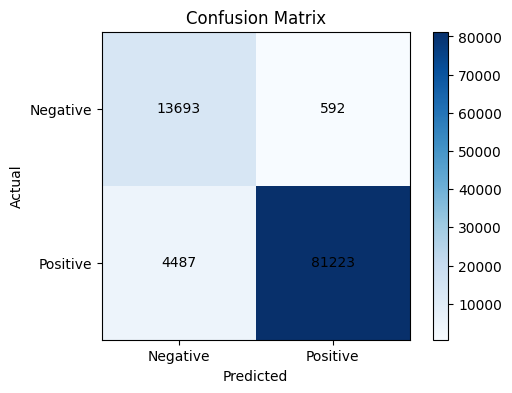

In [46]:
# labels = ['Negative', 'Positive']  # Labels for the classes

# # Create a figure and axes
# fig, ax = plt.subplots(figsize=(6, 4))

# # Create a heatmap for the confusion matrix
# im = ax.imshow(confusion_mat, cmap='Blues')

# # Add colorbar
# cbar = ax.figure.colorbar(im, ax=ax)

# # Set tick labels
# ax.set_xticks(np.arange(len(labels)))
# ax.set_yticks(np.arange(len(labels)))
# ax.set_xticklabels(labels)
# ax.set_yticklabels(labels)

# # Loop over data dimensions and create text annotations
# for i in range(len(labels)):
#     for j in range(len(labels)):
#         text = ax.text(j, i, confusion_mat[i, j], ha='center', va='center', color='black')

# # Set plot labels
# ax.set_xlabel('Predicted')
# ax.set_ylabel('Actual')
# ax.set_title('Confusion Matrix')

# # Display the plot
# plt.show()

In [48]:
# # Calculate prediction accuracy for each category
# accuracy_per_category = df.groupby('category').apply(lambda x: (x['label'] == x['rounded_prediction']).mean())

# # Display the accuracy per category
# print(accuracy_per_category)

category
big_viktor    0.793630
gozi          0.973329
legit         0.958558
matsnu        0.991040
nymaim        0.928946
pizd          1.000000
suppobox      0.998950
dtype: float64


### Enrich / Analyze 
Here you can add other integrations depending on the resources available to your organization (e.g. Domain registration, URL reputation, etc.). Enrichment can help your analysts further interpret results and find interesting leads.
